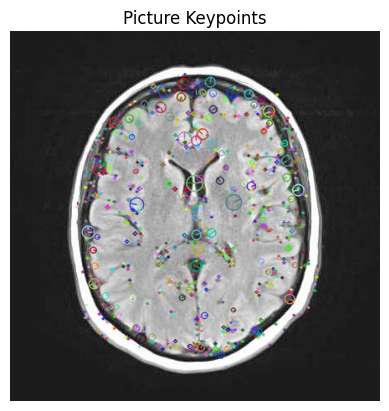

In [2]:
import cv2
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt


#  加载数据
def load_images_from_folder(folder):
    """
    从文件中读取图片并分为训练集和测试集

    Args:
        folder (string): 文件夹路径
        train_size (int): 训练集的大小

    Returns:
        list: 训练集和测试集的图像和标签
    """
    train_images, train_labels = [], []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for i, image_filename in enumerate(os.listdir(path)):
                img = cv2.imread(
                    os.path.join(path, image_filename), cv2.IMREAD_GRAYSCALE
                )
                if img is not None:
                    train_images.append(img)
                    train_labels.append(label)
    return train_images, train_labels


train_folder = "data/Brain_Tumor_Datasets/train"
test_folder = "data/Brain_Tumor_Datasets/test"

X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)


# sift提取特征
def extract_sift_features(X):
    """
    使用sift提取特征

    Args:
        X (list): 图像数据的列表

    Returns:
        list: sift得到的descriptors(128维)和keypoints
    """
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for img in X:
        kp, des = sift.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(des)
        # print(des.shape) # 看看维度，默认特征序列长度为128
    return descriptors, keypoints


def show_features_in_img(X, keypoints):
    """
    用于在图像上画出keypoints

    Args:
        X (list): 图像数据的列表
        keypoints (list): 关键点，包含位置和方向
    """
    # 绘制关键点
    img_with_keypoints = cv2.drawKeypoints(
        X, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # 使用matplotlib显示图
    plt.imshow(img_with_keypoints)
    plt.title("Picture Keypoints")
    plt.axis("off")
    plt.show()


def build_vocabulary(descriptors_list, k):
    """
    使用Kmean方法对特征进行聚类

    Args:
        descriptors_list (list): 图像的SIFT描述符列表，每个元素是一个图像的描述符。
        k (int): 聚类的数量

    Returns:
        KMeans: kmeans模型
    """
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


def features_to_histogram(features, vocab_model):
    """
    通过聚类模型计算一张图上不同种类特征的数量

    Args:
        features (list): 图像的SIFT描述符列表，每个元素是一个图像的描述符。
        vocab_model (KMeans): 训练好的KMeans聚类模型，用于将SIFT描述符映射到视觉词汇。

    Returns:
        array: 一个图像的特征直方图，显示每个视觉词汇的出现频率。
    """
    histogram = np.zeros(len(vocab_model.cluster_centers_))
    words = vocab_model.predict(features)
    for w in words:
        histogram[w] += 1
    return histogram


def prepare_histograms(descriptors_list, vocab_model):
    """
    为每个图像生成特征直方图。

    Args:
        descriptors_list (list): 图像的SIFT描述符列表，每个元素是一个图像的描述符。
        vocab_model (KMeans): 训练好的KMeans聚类模型，用于将SIFT描述符映射到视觉词汇。

    Returns:
        list: 包含每个图像的特征直方图的列表。每个直方图是根据图像的描述符与聚类中心的匹配程度生成的。
    """
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None:
            histogram = features_to_histogram(descriptors, vocab_model)
            histograms.append(histogram)
        else:
            histograms.append(None)
    return histograms


def plot_histogram(histogram):
    """
    绘制特征直方图。

    Args:
        histogram (array): 一个图像的特征直方图，显示每个视觉词汇的出现频率。

    Description:
        这个函数创建一个条形图，显示了在聚类过程中形成的每个视觉词汇在图像中的出现频率。
    """
    # 创建一个条形图
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(histogram)), histogram, color="blue")  # 为每个视觉词生成一个条形
    plt.title("Visual Word Occurrences")
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.show()


def plot_confusion_matrix(cm, class_labels, title="Confusion Matrix"):
    """
    可视化混淆矩阵。

    Args:
        cm (array-like): 混淆矩阵，通常由 sklearn.metrics.confusion_matrix 生成。
        class_labels (list of str): 类别标签列表，用于标记混淆矩阵的行和列。
        title (str, optional): 图表的标题。默认为 'Confusion Matrix'.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="g",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


train_descriptors, train_keypoints = extract_sift_features(X_train)
test_descriptors, test_keypoints = extract_sift_features(X_test)

show_features_in_img(X_train[0], train_keypoints[0])


def test(k, kernel):
    """
    方便测试

    Args:
        k (int): 聚类的数量
        kernel (string): svm的核
    """
    vocab_model = build_vocabulary(train_descriptors, k)

    train_histograms = prepare_histograms(train_descriptors, vocab_model)
    test_histograms = prepare_histograms(test_descriptors, vocab_model)

    plot_histogram(train_histograms[0])

    # 处理可能的None值
    train_histograms = [
        hist if hist is not None else np.zeros(k) for hist in train_histograms
    ]
    test_histograms = [
        hist if hist is not None else np.zeros(k) for hist in test_histograms
    ]

    # SVM训练
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    clf = SVC(kernel=kernel)
    clf.fit(train_histograms, y_train_encoded)

    predictions = clf.predict(test_histograms)
    print(classification_report(y_test_encoded, predictions, target_names=le.classes_))

    cm = confusion_matrix(y_test_encoded, predictions)
    print("Confusion Matrix:")
    print(cm)

    # 可视化混淆矩阵
    plot_confusion_matrix(cm, le.classes_)

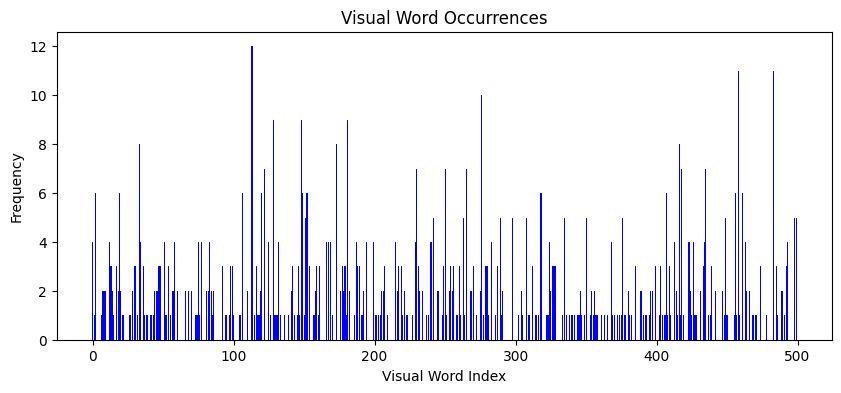

              precision    recall  f1-score   support

          no       0.97      0.98      0.97       717
         yes       0.99      0.98      0.98      1035

    accuracy                           0.98      1752
   macro avg       0.98      0.98      0.98      1752
weighted avg       0.98      0.98      0.98      1752

Confusion Matrix:
[[ 704   13]
 [  25 1010]]


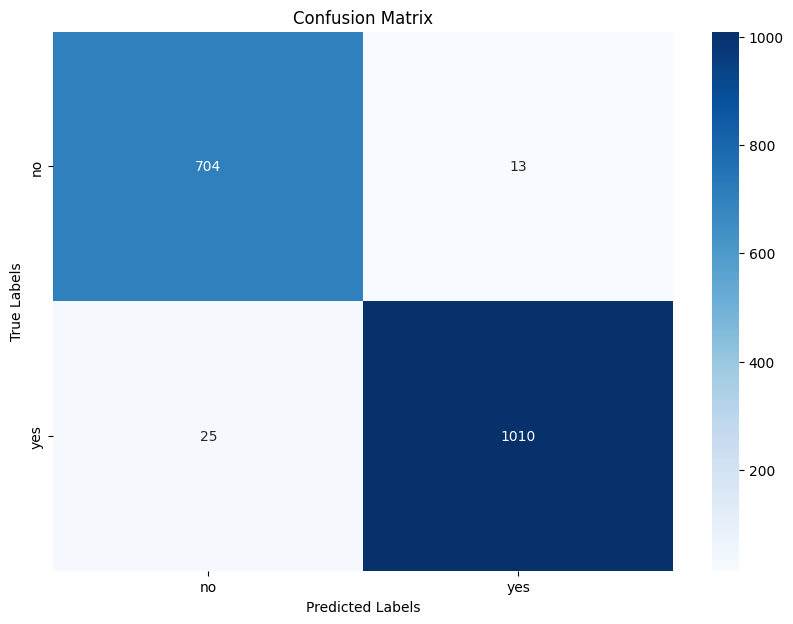

In [3]:
test(500, "rbf")

In [ ]:
from sklearn.externals import joblib

